In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.optimize import root_scalar as root

D:\Mark\Python\lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [258]:
from matplotlib import colormaps as cm
from matplotlib import colors
from matplotlib import cm as cmx

In [250]:
def psi(g,e):
    return np.array([g, e])

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

#def Omega(n,m,eta):
#    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
#        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def Omega(n,eta):
    return np.abs(np.exp(-eta**2/2.0)* L(n,0)(eta**2))

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def expE(nbar, omega, Ncut):
    expE = 0.0
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def dopAndStark(nbar): #gives instantaneous doppler and stark shift in angular frequency units
    Ncut = 1201
    omega = 2.0*np.pi*778e3 #Lange
    Omegarf = 2.0*np.pi*13e6 #Lange
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -2.0*np.pi*nu0*expE(nbar, omega, Ncut)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
#from Lange eqns 2.11 and 2.12

In [213]:
def pulse(t, Omega0, delPrime, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delPrime**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delPrime/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delPrime/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delPrime*t/2.0)*V1@U@V0

def rhoee(psi):
    return abs(psi[1])

def rhogg(psi):
    return abs(psi[0])

def phi(psi):
    phi0 = math.atan2(np.real(psi[0]),np.imag(psi[0]))
    phi1 = math.atan2(np.real(psi[1]),np.imag(psi[1]))
    return (phi0-phi1)

def blochVec(psi):
    w = rhogg(psi) - rhoee(psi)  #pointed up is ground state
    if abs(w)>1.0:
        w = float(round(w))
    x = np.sin(np.arccos(w))*np.cos(phi(psi))
    y = np.sin(np.arccos(w))*np.sin(phi(psi))
    return np.array([x,y,w])

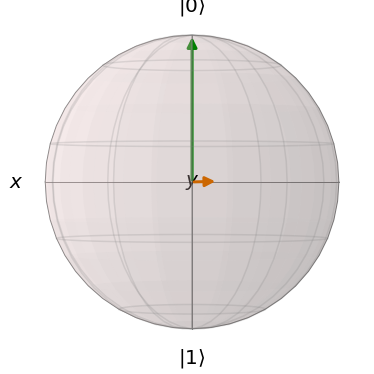

In [111]:
psi0 = psi(1,0)
t1 = 20.0e-3
Omega0 = np.pi/(2.*t1)
delp1 = 2.*np.pi*2.0
pi2Pulse = pulse(t1, Omega0, delp1, 0.0, 0.0)
psi1 = pi2Pulse@psi0

b = Bloch()
b.add_vectors(blochVec(psi0))
b.add_vectors(blochVec(psi1))
b.view = [0,0]
b.show()

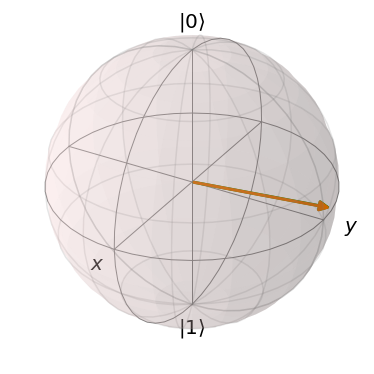

Dark time phase accumulation is -0.0027008038296190175 rad


In [112]:
T = 300e-3
nbarf = 30
deld = (dopAndStark(nbarf)+dopAndStark(0))/2.0
freeEvo = pulse(T, 0.0, deld, 0.0, 0.0)
psi2 = freeEvo@psi1

b = Bloch()
b.add_vectors(blochVec(psi1))
b.add_vectors(blochVec(psi2))
b.show()
print("Dark time phase accumulation is", deld*T, "rad" )

In [118]:
eta = 0.1
omega = Omega0*Omega(nbarf,0,eta)
t2 = 3.0*t1
tpts = 10
ts = np.linspace(0,t2,tpts)
pShift = pulse(0.0,0.0,0.0,0.0,np.pi/2)
mShift = pulse(0.0,0.0,0.0,0.0,-np.pi/2)

psi3p = pShift@psi2
psi3m = mShift@psi2

b = Bloch()
for ii in range(tpts):
    shortPulse = pulse(ts[ii],omega,dopAndStark(nbarf)-dopAndStark(0),0.0,0.0)
    subPsi = shortPulse@psi3p
    b.add_points(blochVec(subPsi))

psi4 = pulse(t2,omega,dopAndStark(nbarf)-dopAndStark(0),0.0,0.0)@psi3p


b.add_vectors(blochVec(psi2))
b.add_vectors(blochVec(psi3p))
b.add_vectors(blochVec(psi4))
b.view = [90,0]
b.show()

TypeError: 'numpy.ndarray' object is not callable

In [114]:
eta = 0.1
omega = Omega0*Omega(nbarf,0,eta)
t2 = 3.0*t1
tpts = 10
ts = np.linspace(0,t2,tpts)
pShift = pulse(0.0,0.0,0.0,0.0,np.pi/2)
mShift = pulse(0.0,0.0,0.0,0.0,-np.pi/2)

psi3p = pShift@psi2
psi3m = mShift@psi2

b = Bloch()
for ii in range(tpts):
    pulse = pulse(ts[ii],omega,dopAndStark(nbarf)-dopAndStark(0),0.0,0.0)
    subPsi = pulse@psi3m
    b.add_points(blochVec(subPsi))

psi4 = pulse(t2,omega,dopAndStark(nbarf)-dopAndStark(0),0.0,0.0)@psi3m


b.add_vectors(blochVec(psi2))
b.add_vectors(blochVec(psi3m))
b.add_vectors(blochVec(psi4))
b.view = [-90,0]
b.show()

TypeError: 'numpy.ndarray' object is not callable

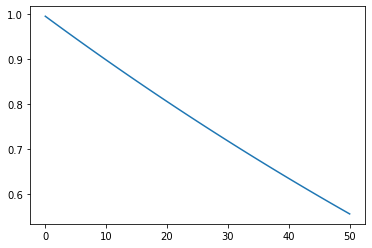

In [72]:
pts = 51
omegas = np.zeros(pts)
eta=0.1
for ii in range(pts):
    omegas[ii] = Omega(ii,0,eta)
    
plt.plot(omegas)
plt.show()

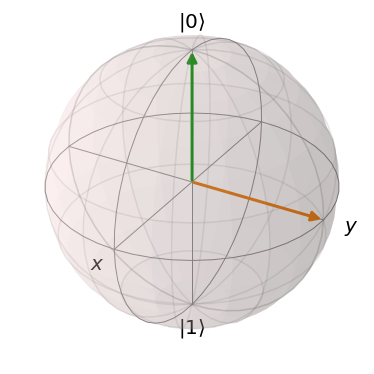

In [76]:
psi0 = psi(1,0)
t1 = 20.0e-3
Omega0 = np.pi/(2.*t1)
pi2Pulse = pulse(t1, Omega0, 0.0, 0.0, 0.0)
psi1 = pi2Pulse@psi0

b = Bloch()
b.add_vectors(blochVec(psi0))
b.add_vectors(blochVec(psi1))
b.show()

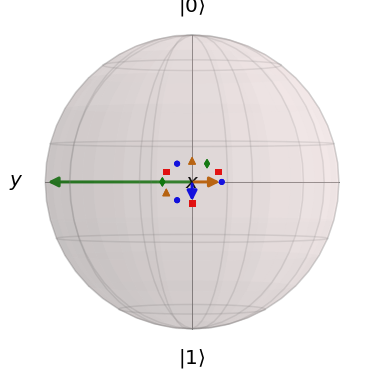

In [99]:
eta = 0.0
nbarf = 0
omega = Omega0*Omega(nbarf,0,eta)
t2 = 3.0*t1
tpts = 10
ts = np.linspace(0,t2,tpts)
pShift = pulse(0.0,0.0,0.0,0.0,np.pi/2)
mShift = pulse(0.0,0.0,0.0,0.0,-np.pi/2)

deld = 2.0*np.pi*0.1
psi2 = pulse(300e-3,0.0,deld,0.0,0.0)@psi1
psi3p = pShift@psi2
psi3m = mShift@psi2
 

b = Bloch()
for ii in range(tpts):
    pulse = pulse(ts[ii],omega,0.0,0.0,0.0)
    subPsi = pulse@psi3m
    b.add_points(blochVec(subPsi))

    

psi4 = pulse(t2,omega,0.0,0.0,0.0)@psi3m


b.add_vectors(blochVec(psi2))
b.add_vectors(blochVec(psi3m))
b.add_vectors(blochVec(psi4))
b.view = [90,0]
b.show()

# Bloch sphere heat map

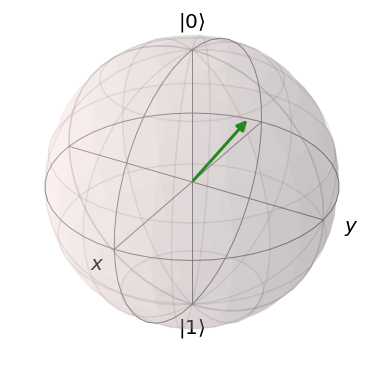

-0.1547446607299396


In [307]:
psi0 = psi(1.0,0.0) #ground state
#pulse(t, Omega0, delPrime, phi0, phi1):
delp = 0.1
psi1 = pulse(np.pi/2.0, 1.0, delp, 0.0, 0.0)@psi0

T = 300e-3
nbarf = 30
deld = (dopAndStark(nbarf)+dopAndStark(0))/2.0
phase = T*deld

psi2 = pulse(0.0,0.0,0.0,0.0,-np.pi/2.0)@pulse(0.0,0.0,0.0,0.0,phase)@psi1
b = Bloch()
b.add_vectors(blochVec(psi2))
b.show()
print(phase*(180/np.pi))

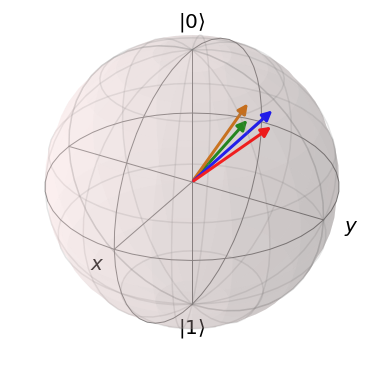

In [308]:
psi3 = pulse(np.pi/2, 1.0, delp, 0.0, 0.0)@psi2
psi4 = pulse(np.pi, 1.0, delp, 0.0, 0.0)@psi2
psi5 = pulse(3.0*np.pi/2.0, 1.0, delp, 0.0, 0.0)@psi2
psi6 = pulse(4.0*np.pi/2.0, 1.0, delp, 0.0, 0.0)@psi2
psi7 = pulse(5.0*np.pi/2.0, 1.0, delp, 0.0, 0.0)@psi2
b = Bloch()
b.add_vectors(blochVec(psi2))
b.add_vectors(blochVec(psi3))
b.add_vectors(blochVec(psi4))
b.add_vectors(blochVec(psi5))
b.show()

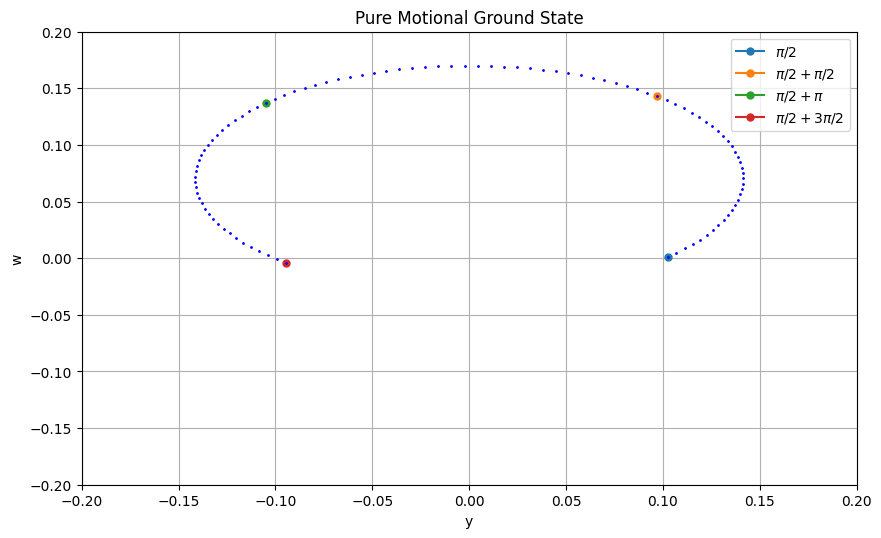

In [288]:
tpts = 100
ts = np.linspace(0,3.0*np.pi/2.0, tpts)
ws = np.zeros(tpts)
ys = np.zeros(tpts)
for ii in range(tpts):
    state = pulse(ts[ii],1.0,delp,0.0,0.0)@psi2
    ws[ii] = blochVec(state)[2]
    ys[ii] = -blochVec(state)[1]

w2 = blochVec(psi2)[2]
y2 = -blochVec(psi2)[1]
w3 = blochVec(psi3)[2]
y3 = -blochVec(psi3)[1]
w4 = blochVec(psi4)[2]
y4 = -blochVec(psi4)[1]
w5 = blochVec(psi5)[2]
y5 = -blochVec(psi5)[1]
w6 = blochVec(psi6)[2]
y6 = -blochVec(psi6)[1]
w7 = blochVec(psi7)[2]
y7 = -blochVec(psi7)[1]
plt.figure(figsize=(10,6), dpi=100)
plt.plot(y2,w2,marker="o",markersize="5",label=r"$\pi/2 $")
plt.plot(y3,w3,marker="o",markersize="5",label=r"$\pi/2 + \pi/2$")
plt.plot(y4,w4,marker="o",markersize="5",label=r"$\pi/2 + \pi$")
plt.plot(y5,w5,marker="o",markersize="5",label=r"$\pi/2 + 3\pi/2$")
for ii in range(tpts):
    plt.plot(ys[ii], ws[ii], marker="o",markersize="1", color='b')
plt.xlim([-0.2,0.2])
plt.ylim([-0.2,0.2])
plt.grid()
plt.legend()
plt.xlabel("y")
plt.ylabel("w")
plt.title("Pure Motional Ground State")
plt.show()

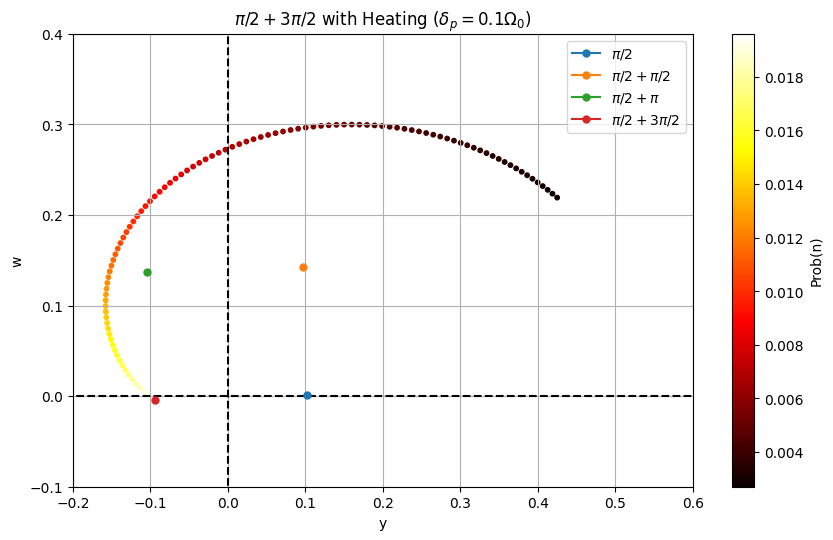

In [311]:
T = 300e-3
nbarf = 50
deld = (dopAndStark(nbarf)+dopAndStark(0))/2.0
phase = T*deld
psi2 = pulse(0.0,0.0,0.0,0.0,-np.pi/2.0)@pulse(0.0,0.0,0.0,0.0,phase)@pulse(np.pi/2.0, 1.0, delp, 0.0, 0.0)@psi(1.0,0.0)

pts = 101
ns = np.linspace(0,pts-1,pts)
omegas = np.zeros(pts)
ws = np.zeros(pts)
ys = np.zeros(pts)
probs = np.zeros(pts)
eta = 0.1

for ii in range(pts):
    omegas[ii] = Omega(ns[ii],eta)
    state = pulse(3.0*np.pi/2.0, omegas[ii], delp, 0.0, 0.0)@psi2
    ws[ii] = blochVec(state)[2]
    ys[ii] = -blochVec(state)[1]
    probs[ii] = prob(ns[ii],nbarf)

plt.figure(figsize=(10,6), dpi=100)
plt.plot([-1,1],[0,0],linestyle='dashed',color='black')
plt.plot([0,0],[-1,1],linestyle='dashed',color='black')
plt.plot(y2,w2,marker="o",markersize="5",label=r"$\pi/2 $")
plt.plot(y3,w3,marker="o",markersize="5",label=r"$\pi/2 + \pi/2$")
plt.plot(y4,w4,marker="o",markersize="5",label=r"$\pi/2 + \pi$")
plt.plot(y5,w5,marker="o",markersize="5",label=r"$\pi/2 + 3\pi/2$")
#for ii in range(pts):
#    plt.plot(ys[ii], ws[ii], marker="o",markersize="1", color=colorVals[ii])
plt.scatter(x= ys, y=ws, c=probs, cmap = "hot" ,s=10)
lim=0.6
plt.xlim([-0.2,lim])
plt.ylim([-0.1,0.4])
plt.grid()
plt.legend()
plt.xlabel("y")
plt.ylabel("w")
plt.title(r"$\pi/2 + 3\pi/2$ with Heating ($\delta_p=0.1\Omega_0$)")
plt.colorbar(label="Prob(n)")
plt.show()

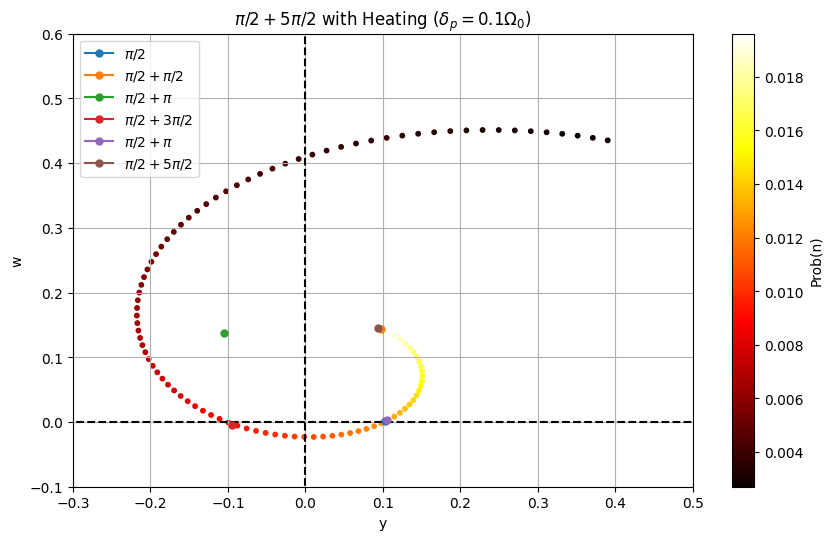

In [310]:
T = 300e-3
nbarf = 50
deld = (dopAndStark(nbarf)+dopAndStark(0))/2.0
phase = T*deld
psi2 = pulse(0.0,0.0,0.0,0.0,-np.pi/2.0)@pulse(0.0,0.0,0.0,0.0,phase)@pulse(np.pi/2.0, 1.0, delp, 0.0, 0.0)@psi(1.0,0.0)

pts = 101
ns = np.linspace(0,pts-1,pts)
omegas = np.zeros(pts)
ws = np.zeros(pts)
ys = np.zeros(pts)
probs = np.zeros(pts)
eta = 0.1

for ii in range(pts):
    omegas[ii] = Omega(ns[ii],eta)
    state = pulse(5.0*np.pi/2.0, omegas[ii], delp, 0.0, 0.0)@psi2
    ws[ii] = blochVec(state)[2]
    ys[ii] = -blochVec(state)[1]
    probs[ii] = prob(ns[ii],nbarf)

plt.figure(figsize=(10,6), dpi=100)
plt.plot([-1,1],[0,0],linestyle='dashed',color='black')
plt.plot([0,0],[-1,1],linestyle='dashed',color='black')
plt.plot(y2,w2,marker="o",markersize="5",label=r"$\pi/2 $")
plt.plot(y3,w3,marker="o",markersize="5",label=r"$\pi/2 + \pi/2$")
plt.plot(y4,w4,marker="o",markersize="5",label=r"$\pi/2 + \pi$")
plt.plot(y5,w5,marker="o",markersize="5",label=r"$\pi/2 + 3\pi/2$")
plt.plot(y6,w6,marker="o",markersize="5",label=r"$\pi/2 + \pi$")
plt.plot(y7,w7,marker="o",markersize="5",label=r"$\pi/2 + 5\pi/2$")
plt.scatter(x= ys, y=ws, c=probs, cmap = "hot" ,s=10)
plt.xlim([-0.3,0.5])
plt.ylim([-0.1,0.6])
plt.grid()
plt.legend()
plt.xlabel("y")
plt.ylabel("w")
plt.title(r"$\pi/2 + 5\pi/2$ with Heating ($\delta_p=0.1\Omega_0$)")
plt.colorbar(label="Prob(n)")

plt.show()

# Trying to figure out that jump in the HRS curve w/ no detuning

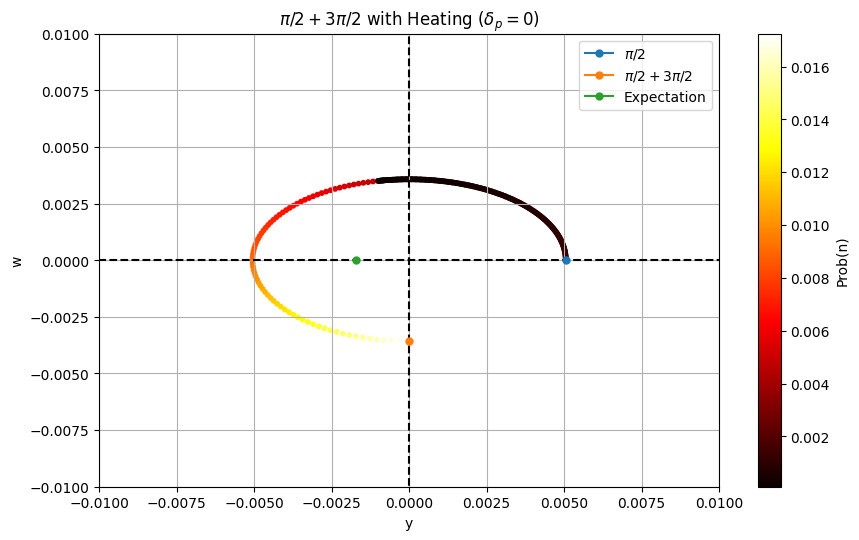

In [339]:
T = 300e-3
nbarf = 57
deld = (dopAndStark(nbarf)+dopAndStark(0))/2.0
phase = T*deld
delp = 0.0
t1 = 20e-3
Omega0 = np.pi/(2.0*t1)
t2 = 3.0*t1
psi2 = pulse(0.0,0.0,0.0,0.0,-np.pi/2.0)@pulse(0.0,0.0,0.0,0.0,phase)@pulse(t1, Omega0, delp, 0.0, 0.0)@psi(1.0,0.0)
psi5 = pulse(t2, Omega0, delp, 0.0, 0.0)@psi2
w2 = blochVec(psi2)[2]
y2 = -blochVec(psi2)[1]
w5 = blochVec(psi5)[2]
y5 = -blochVec(psi5)[1]


pts = 301
ns = np.linspace(0,pts-1,pts)
omegas = np.zeros(pts)
ws = np.zeros(pts)
ys = np.zeros(pts)
probs = np.zeros(pts)
eta = 0.1

wCoM = 0.0
yCoM = 0.0

for ii in range(pts):
    omegas[ii] = Omega(ns[ii],eta)*Omega0
    state = pulse(t2, omegas[ii], delp, 0.0, 0.0)@psi2
    ws[ii] = blochVec(state)[2]
    ys[ii] = -blochVec(state)[1]
    probs[ii] = prob(ns[ii],nbarf)
    wCoM += probs[ii]*ws[ii]
    yCoM += probs[ii]*ys[ii]

plt.figure(figsize=(10,6), dpi=100)
plt.plot([-1,1],[0,0],linestyle='dashed',color='black')
plt.plot([0,0],[-1,1],linestyle='dashed',color='black')
plt.plot(y2,w2,marker="o",markersize="5",label=r"$\pi/2 $")
#plt.plot(y3,w3,marker="o",markersize="5",label=r"$\pi/2 + \pi/2$")
#plt.plot(y4,w4,marker="o",markersize="5",label=r"$\pi/2 + \pi$")
plt.plot(y5,w5,marker="o",markersize="5",label=r"$\pi/2 + 3\pi/2$")
plt.plot(yCoM,wCoM,marker="o",markersize="5",label="Expectation")
plt.scatter(x= ys, y=ws, c=probs, cmap = "hot" ,s=10)
plt.xlim([-0.01,0.01])
plt.ylim([-0.01,0.01])
plt.grid()
plt.legend()
plt.xlabel("y")
plt.ylabel("w")
plt.title(r"$\pi/2 + 3\pi/2$ with Heating ($\delta_p=0$)")
plt.colorbar(label="Prob(n)")

plt.show()